In [1]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import io
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor, ViTImageProcessor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

D:\anaconda\envs\vit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [2]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224"
#     ENCODER = "VIT_large_gpt2-4epoch-aesthetic-PCCD-4k"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 2
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [3]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [4]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

C:\Users\CVIU\AppData\Local\Temp\ipykernel_13512\2887452628.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


In [5]:
feature_extractor = ViTImageProcessor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

In [6]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(config.IMG_SIZE), 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=0.5, 
            std=0.5
        ),
        torchvision.transforms.ToPILImage()  # 新增步驟
   ]
)
df=  pd.read_csv("./PCCD4k/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

image                                            caption
0             25_honu.jpg  The depth of field is good, as said before, bu...
1  27_pronghorn-prowl.jpg  This is a good shot Mike, and I would be glad ...
2  27_pronghorn-prowl.jpg  The shallow depth of field helps bring focused...
3  27_pronghorn-prowl.jpg  I cannot tell if the focus is right on for his...
4  27_pronghorn-prowl.jpg  The pronghorn harem buck is coming to check ou...

In [7]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 502
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding

In [8]:
train_dataset = ImgDataset(train_df, root_dir = "./PCCD4k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "./PCCD4k/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)
# print(len(train_dataset))
# print(train_dataset[0])

In [9]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.11.crossattention.q_attn.bias', 'h.3.crossattention.c_proj.weight', 'h.4.crossattention.c_proj.weight', 'h.11.crossattention.q_attn.weight', 'h.1.crossattention.c_proj.weight', 'h.7.crossattention.q_attn.weight', 'h.5.crossattention.c_attn.bias', 'h.6.ln_cross_attn.weight', 'h.4.crossattention.c_attn.weight', 'h.4.crossattention.q_attn.bias', 'h.7.crossattention.c_attn.bias', 'h.7.crossattention.q_attn.bias', 'h.10.ln_cross_attn.bias', 'h.3.crossattention.q_attn.weight', 'h.3.crossattention.c_attn.bias', 'h.7.crossattention.c_proj.bias', 'h.7.crossattention.c_proj.weight', 'h.1.ln_

In [10]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 502
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2-2epoch-aesthetic-PCCD-4k',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config .VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [12]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

D:\anaconda\envs\vit\lib\site-packages\transformers\generation\utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


TrainOutput(global_step=5918, training_loss=3.3644279848687266, metrics={'train_runtime': 128475.4201, 'train_samples_per_second': 0.368, 'train_steps_per_second': 0.046, 'total_flos': 8.542799677844619e+18, 'train_loss': 3.3644279848687266, 'epoch': 2.0})

In [13]:
trainer.save_model('VIT_large_gpt2-2epoch-aesthetic-PCCD-4k')

In [14]:
# model = ViTFeatureExtractor.from_pretrained("VIT_large_gpt2-4epoch-aesthetic-PCCD-4k")

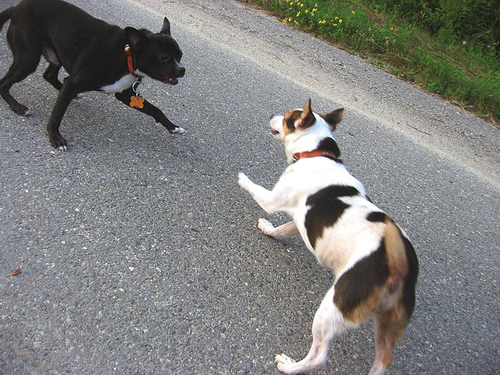

In [15]:
img =  Image.open("./flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [16]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>I like the composition and perspective of this image.  I like the fact that the subject is in the center of the frame, and the way the dog is positioned in the frame.   I also like the placement of the dog's head on the right side of the image, which is a good thing.  The dog's position on the left side is also a good idea, as is the way he is positioned on the top right corner of the photo.  Overall, I think this is a very good image, and I think you have a good eye for composition.  Below are some ideas you may wish to consider to bring out some of the elements that you may have missed in the image that may have been there in the first place.  Thanks for sharing your image with me!   Cheers,Paul.  ~Paul   ~Best regards,Paul  ~Sharon  <|endoftext|>


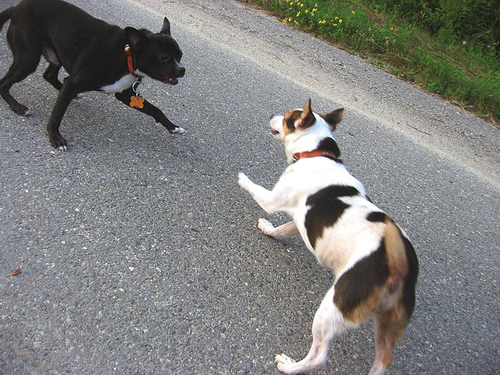

In [17]:
img =  Image.open("./flickr8k/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [18]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>I like the composition and perspective of this image.  I like the fact that the subject is in the center of the frame, and the way the dog is positioned in the frame.   I also like the placement of the dog's head on the right side of the image, which is a good thing.  The dog's position on the left side is also a good idea, as is the way he is positioned on the top right corner of the photo.  Overall, I think this is a very good image, and I think you have a good eye for composition.  Below are some ideas you may wish to consider to bring out some of the elements that you may have missed in the image that may have been there in the first place.  Thanks for sharing your image with me!   Cheers,Paul.  ~Paul   ~Best regards,Paul  ~Sharon  <|endoftext|>


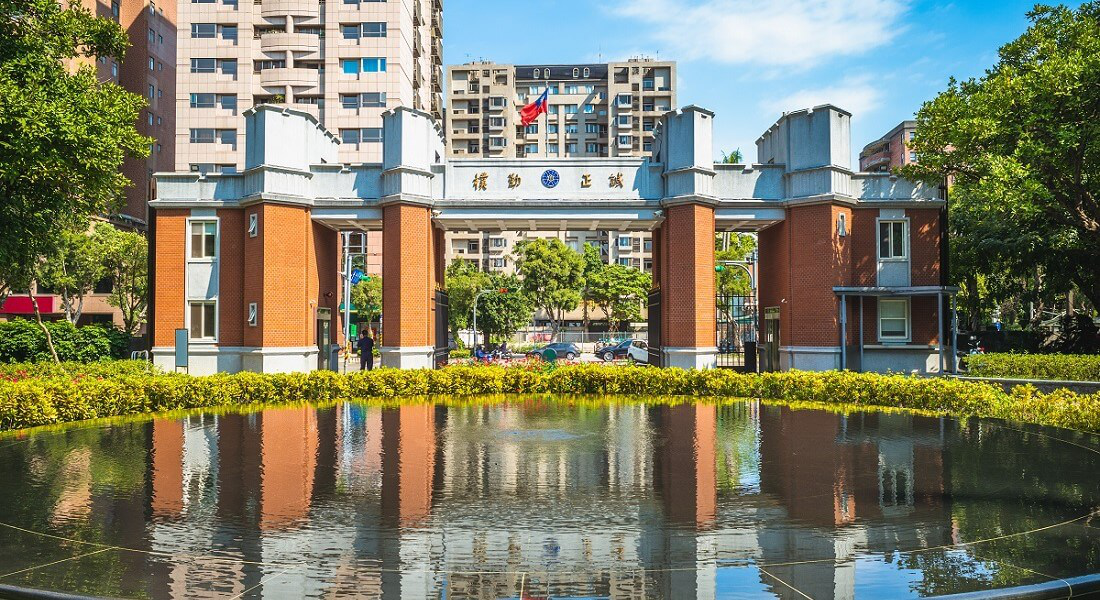

In [19]:
img =  Image.open("ntnu.jpg").convert("RGB")
img

In [20]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>I like the composition and perspective of this image.  I like the fact that you have placed your subject in the center of the frame.   I also like the way you have positioned your subject to the right of the photo.  You have placed the subject directly in the middle of the image, which is a good thing.  The fact that your subject is placed in the lower third of the composition makes it a very interesting composition.  Below are some ideas you may wish to consider to bring out some of the other elements in the image that make this image stand out from the rest.  Thanks for sharing your image with me.  Keep up the good work!   Paul   ~Paul  ~   Robyn   -   Keep Up the Good Work!  ~ Paul   --Paul  --Best regards,   Paul  --Cheers,  David  --   Scott  <|endoftext|>


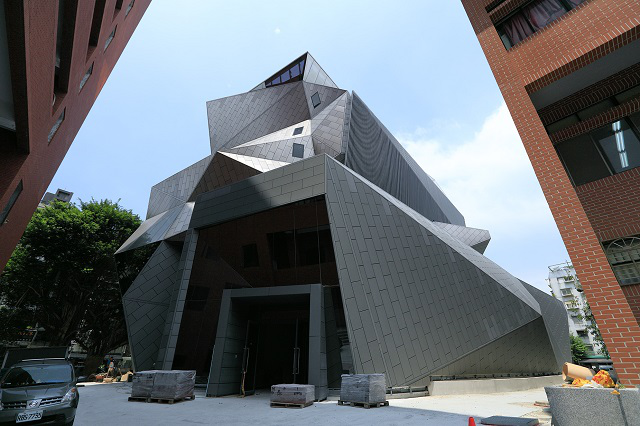

In [21]:
img =  Image.open("4.jpg").convert("RGB")
img

In [22]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>I like the composition and perspective of this image.  I like the fact that the subject is in the center of the frame.   I also like the way you have placed the subject on the right side of the image, which gives the viewer a sense of scale.  The fact that you have positioned the subject so close to the viewer is a good thing.  It adds to the overall feel of the shot.  Below are some ideas for you to consider.  1.  Use a tripod.  If you are using a tripod, you will need to use a longer focal length lens.  This will give you greater depth of field.  Also, you may want to consider using a smaller aperture (f/5.6 or f/11) to give you a greater depth-of-field.  In this case, f/8 would have been better.  2.  Try to shoot from a higher angle.  Using a tripod is a great way to get the viewer's attention to the subject.  You will also benefit from using a wider aperture to get a more sharp image. 3.  Do not use a wide angle lens at all.  A longer lens would have given you a sharpe

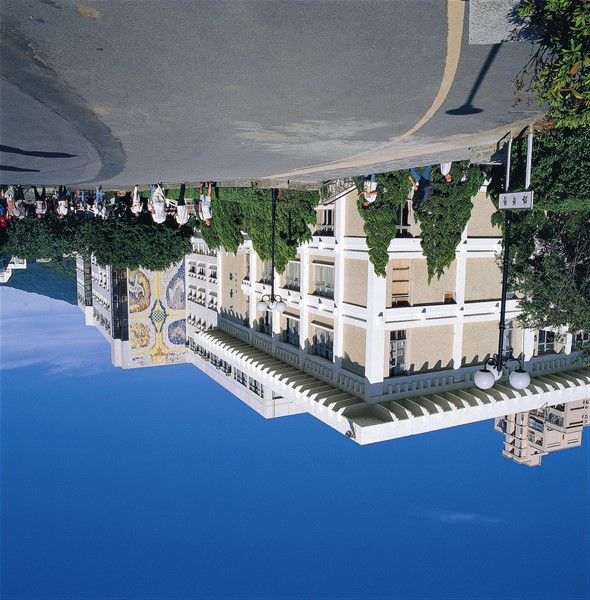

In [23]:
img =  Image.open("engineer.jpg").convert("RGB")
img

In [24]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>This is a very nice image Leonard.  I like the way you have captured the mood of the scene.  It is a good example of how you can use your camera's capabilities to your advantage.  Below are some ideas you may wish to consider to bring out some of the qualities of this image.   I hope that you find these suggestions helpful.  Keep up the good work!   Paul,  I look forward to seeing more of your work.  You have a great eye for composition and you have a very good eye for capturing the mood you want to convey.  See you soon!Paul, I hope you find my suggestions helpful and that you continue to work on your photographic skills.  Thanks for sharing your work with me.Cheers,Paul.Paul,Best regards,Paul  See you soon.Paul Cheers!Paul Paul<|endoftext|>


In [25]:
img =  Image.open("./flickr8k/Images/1000268201_693b08cb0e.jpg").convert("RGB")
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:]+ '\033[0m')

<|endoftext|>I like the composition and perspective of this image.  I like the fact that the subject is in the center of the frame.   I also like the way you have placed the subject in the middle of the image, which is a good thing.  There are a couple of things you could do to make this image more interesting.  First, you could have moved the subject a bit to the right to make it more prominent in the frame, or to the left to make the subject pop out a bit more.  Also, if you were to crop the image a little more, you would have more of the subject's face in the lower right corner.  This would make the image pop out more, and make the viewer think more about the subject.  Below are some ideas you may wish to consider to bring out the subject and make it pop a bit further. ... .    A little more space on the right side of the photo would help to bring the viewer's attention to the subject, which would also add a bit of interest to the composition.  The image is also a bit too centered, 